In [1]:
!unzip data.zip

Archive:  data.zip
  inflating: predictive_maintenance.csv  


In [ ]:
# 1. 라이브러리 임포트 및 데이터 로딩
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

# 모델 라이브러리
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')

# 데이터 불러오기
try:
    df = pd.read_csv('/content/predictive_maintenance.csv')
except FileNotFoundError:
    print("Error: '/content/predictive_maintenance.csv' 파일을 찾을 수 없습니다.")
    df = pd.DataFrame()

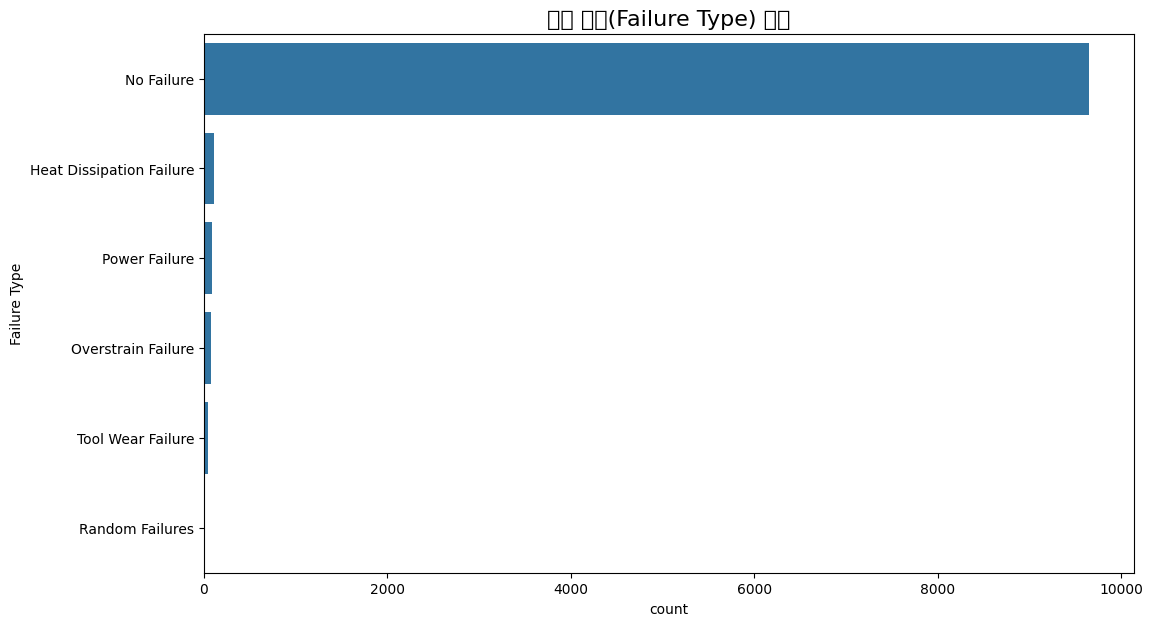

In [21]:
# 2. 데이터 분석 (EDA)

# --- 2.1 타겟 변수(Failure Type) 분포 ---
plt.figure(figsize=(12, 7))
sns.countplot(y='Failure Type', data=df, order = df['Failure Type'].value_counts().index)
plt.title('고장 유형(Failure Type) 분포', fontsize=16)
plt.show()

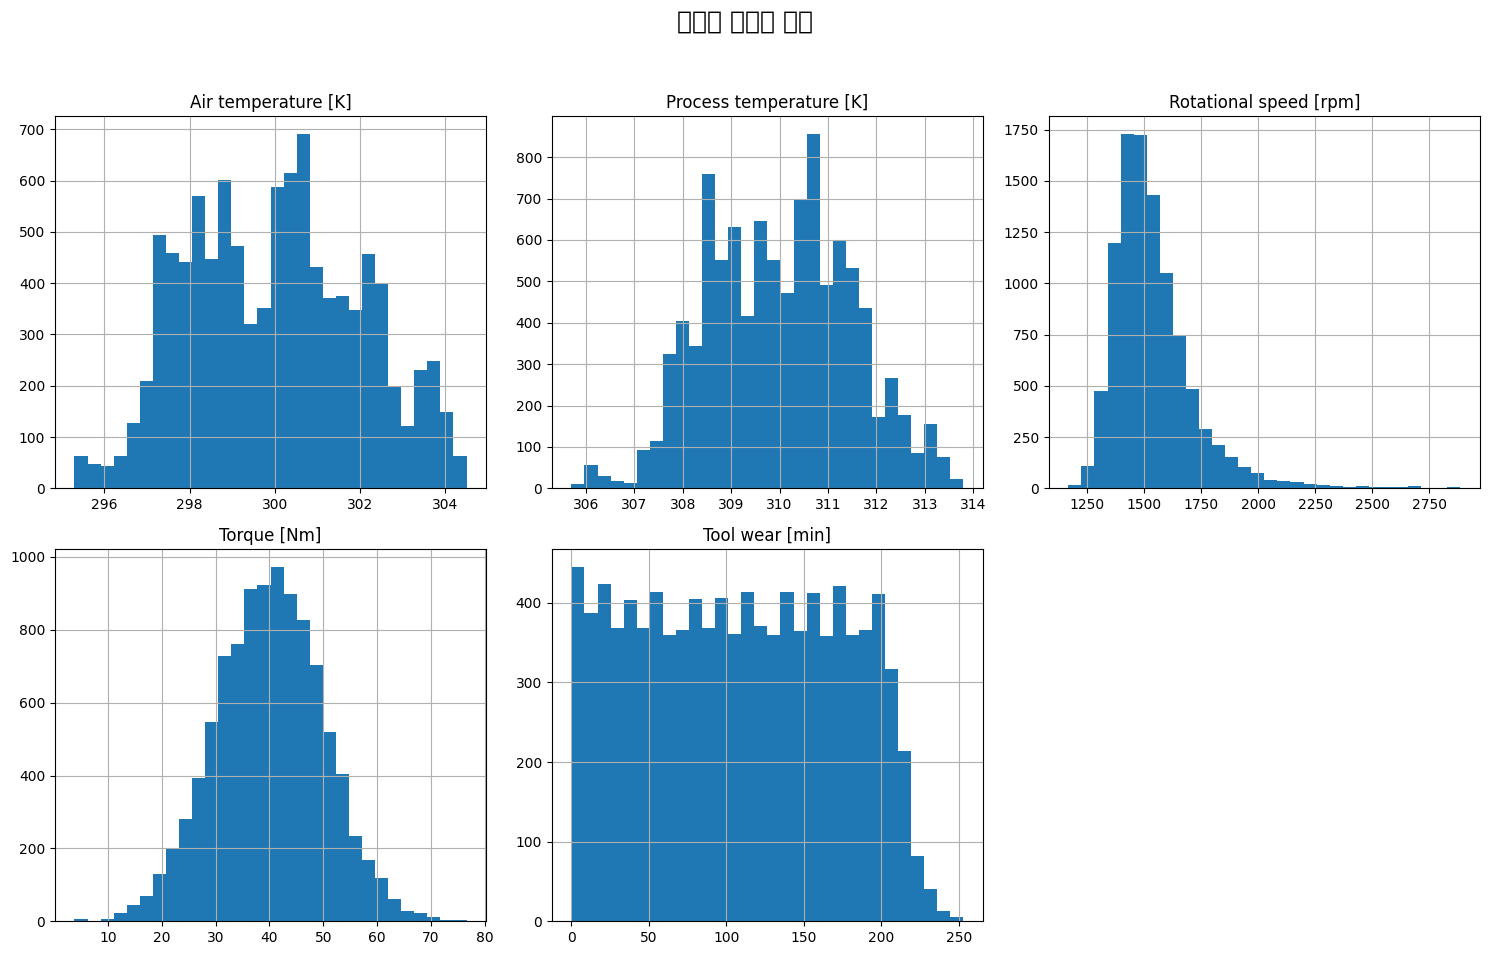

In [22]:
# --- 2.2 수치형 데이터 분포 시각화 ---
numeric_features = df.select_dtypes(include=np.number).drop(columns=['UDI', 'Target']).columns
df[numeric_features].hist(bins=30, figsize=(15, 10), layout=(2, 3))
plt.suptitle('수치형 데이터 분포', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

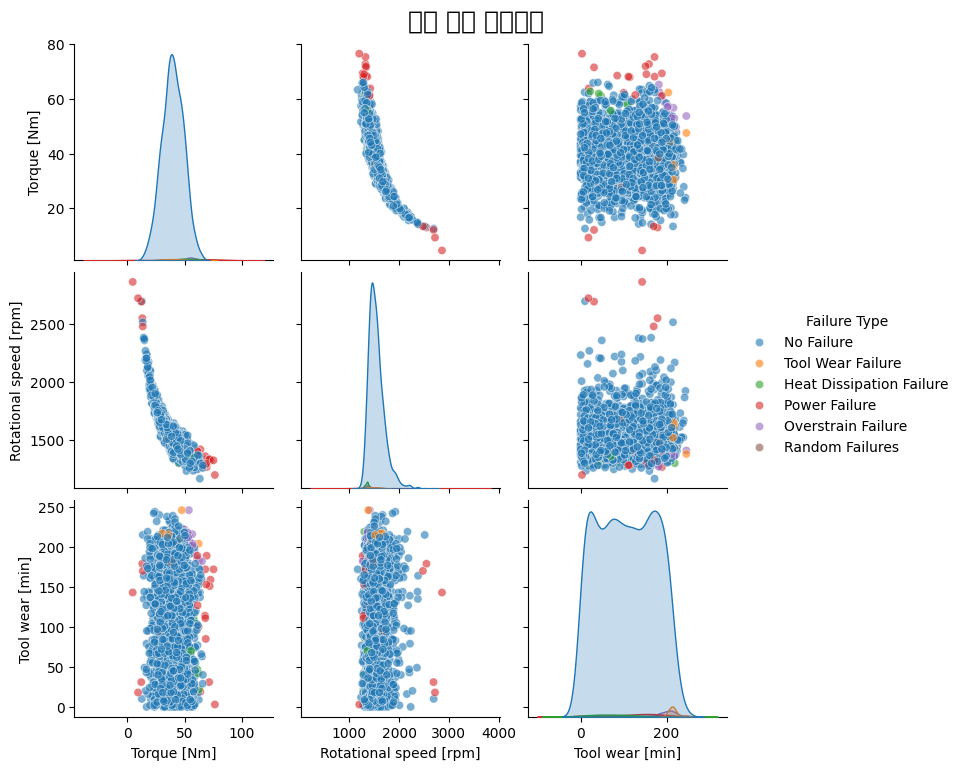

In [23]:
# --- 2.3 핵심 피처 페어플롯 (Pair Plot) ---
# 샘플링하여 시각화 (시간 단축)
sample_df = df.sample(n=2000, random_state=42)
pair_features = ['Torque [Nm]', 'Rotational speed [rpm]', 'Tool wear [min]', 'Failure Type']
sns.pairplot(sample_df[pair_features], hue='Failure Type', plot_kws={'alpha': 0.6})
plt.suptitle('핵심 피처 페어플롯', y=1.02, fontsize=18)
plt.show()

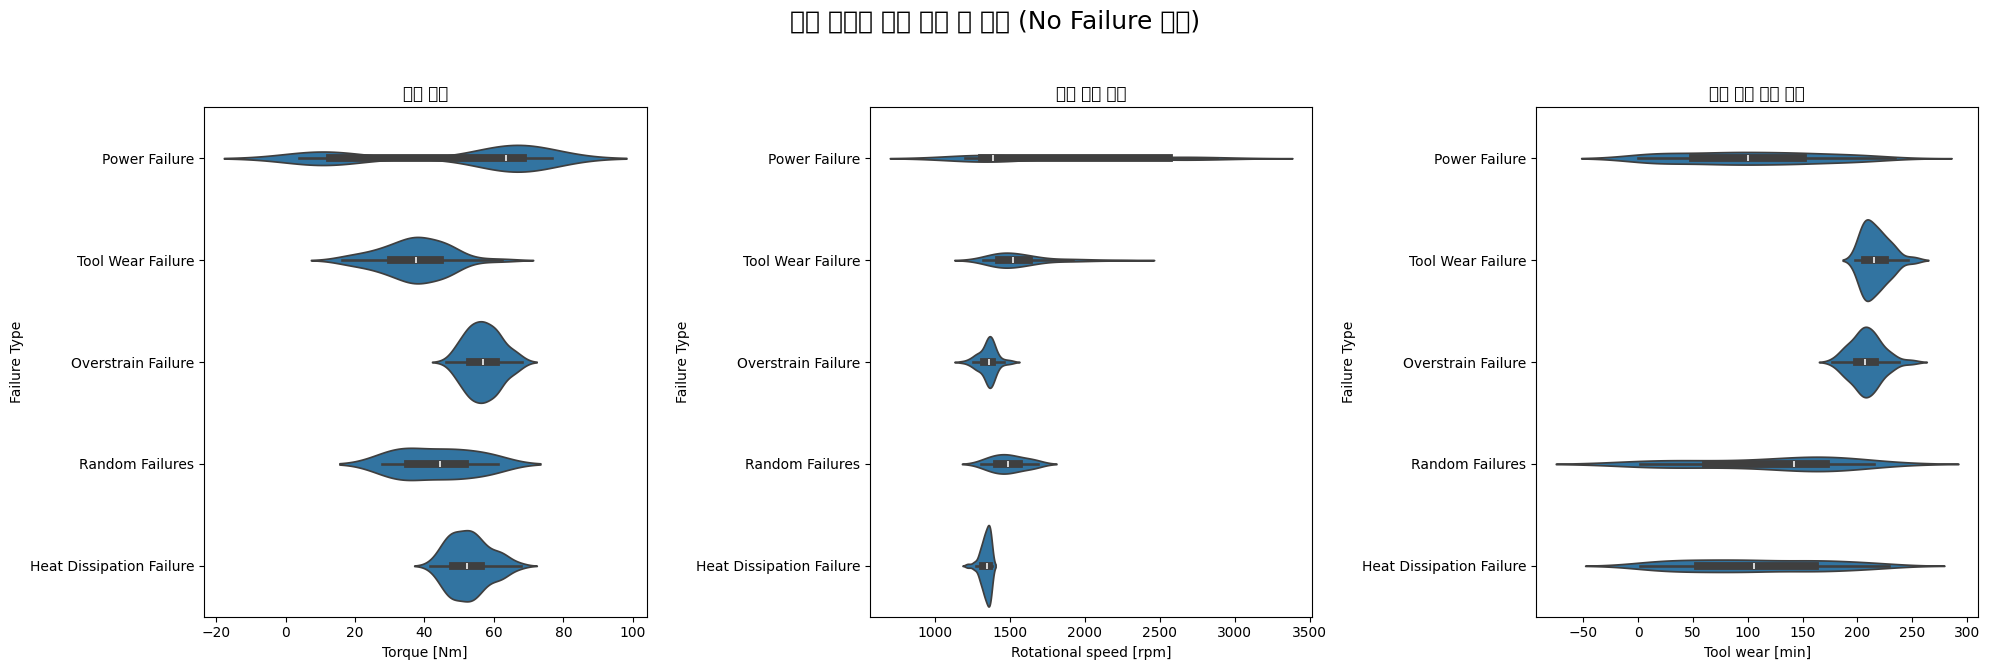

In [24]:
# --- 2.4 고장 유형별 센서 값 분포 (바이올린 플롯) ---
fig, axes = plt.subplots(1, 3, figsize=(20, 7))
fig.suptitle('고장 유형별 주요 센서 값 분포 (No Failure 제외)', fontsize=18)
plot_df = df[df['Failure Type'] != 'No Failure']

sns.violinplot(y='Failure Type', x='Torque [Nm]', data=plot_df, ax=axes[0])
axes[0].set_title('토크 분포')
sns.violinplot(y='Failure Type', x='Rotational speed [rpm]', data=plot_df, ax=axes[1])
axes[1].set_title('회전 속도 분포')
sns.violinplot(y='Failure Type', x='Tool wear [min]', data=plot_df, ax=axes[2])
axes[2].set_title('공구 마모 시간 분포')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [25]:
# 3. 데이터 전처리

df_processed = df.drop(columns=['UDI', 'Product ID', 'Target'])
X = df_processed.drop('Failure Type', axis=1)
y = df_processed['Failure Type']

le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("인코딩된 클래스:", list(le.classes_))

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.25, random_state=42, stratify=y_encoded
)

categorical_features = ['Type']
numeric_features = X.select_dtypes(include=np.number).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough' # 처리되지 않은 컬럼은 그대로 둠
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)
print(" 데이터 전처리 완료")

인코딩된 클래스: ['Heat Dissipation Failure', 'No Failure', 'Overstrain Failure', 'Power Failure', 'Random Failures', 'Tool Wear Failure']
 데이터 전처리 완료


In [ ]:
# 4. 다중 모델 학습 및 비교

models = {
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'XGBoost': xgb.XGBClassifier(random_state=42, objective='multi:softmax'),
    'LightGBM': lgb.LGBMClassifier(random_state=42, objective='multiclass', class_weight='balanced')
}

predictions = {}
model_results = {}

for name, model in models.items():
    print(f" {name} 모델 학습 시작...")
    model.fit(X_train_processed, y_train)
    y_pred = model.predict(X_test_processed)
    predictions[name] = y_pred

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    model_results[name] = {'Accuracy': accuracy, 'F1 Score (Macro)': f1}
    print(f" {name} 모델 학습 완료 (Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f})")

 Logistic Regression 모델 학습 시작...
 Logistic Regression 모델 학습 완료 (Accuracy: 0.6472, F1 Score: 0.3807)
 Random Forest 모델 학습 시작...
 Random Forest 모델 학습 완료 (Accuracy: 0.9784, F1 Score: 0.4910)
 XGBoost 모델 학습 시작...
 XGBoost 모델 학습 완료 (Accuracy: 0.9860, F1 Score: 0.5943)
 LightGBM 모델 학습 시작...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 927
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 8
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791760
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

In [ ]:
# 5. 심층 결과 분석 및 최종 모델 선정

results_df = pd.DataFrame(model_results).T.sort_values(by='F1 Score (Macro)', ascending=False)
print("--- 모델별 종합 성능 비교 표 ---")
print(results_df)

best_model_name = results_df.index[0]
print(f"\n 최적 모델: {best_model_name}")


--- 모델별 종합 성능 비교 표 ---
                     Accuracy  F1 Score (Macro)
LightGBM               0.9844          0.607759
XGBoost                0.9860          0.594285
Random Forest          0.9784          0.490972
Logistic Regression    0.6472          0.380690

 최적 모델: LightGBM


In [ ]:
# --- 5.2 최적 모델 상세 분석 (Classification Report) ---
best_pred = predictions[best_model_name]
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(best_pred)

print(f"\n--- {best_model_name} 상세 분류 리포트 ---")
print(classification_report(y_test_labels, y_pred_labels))

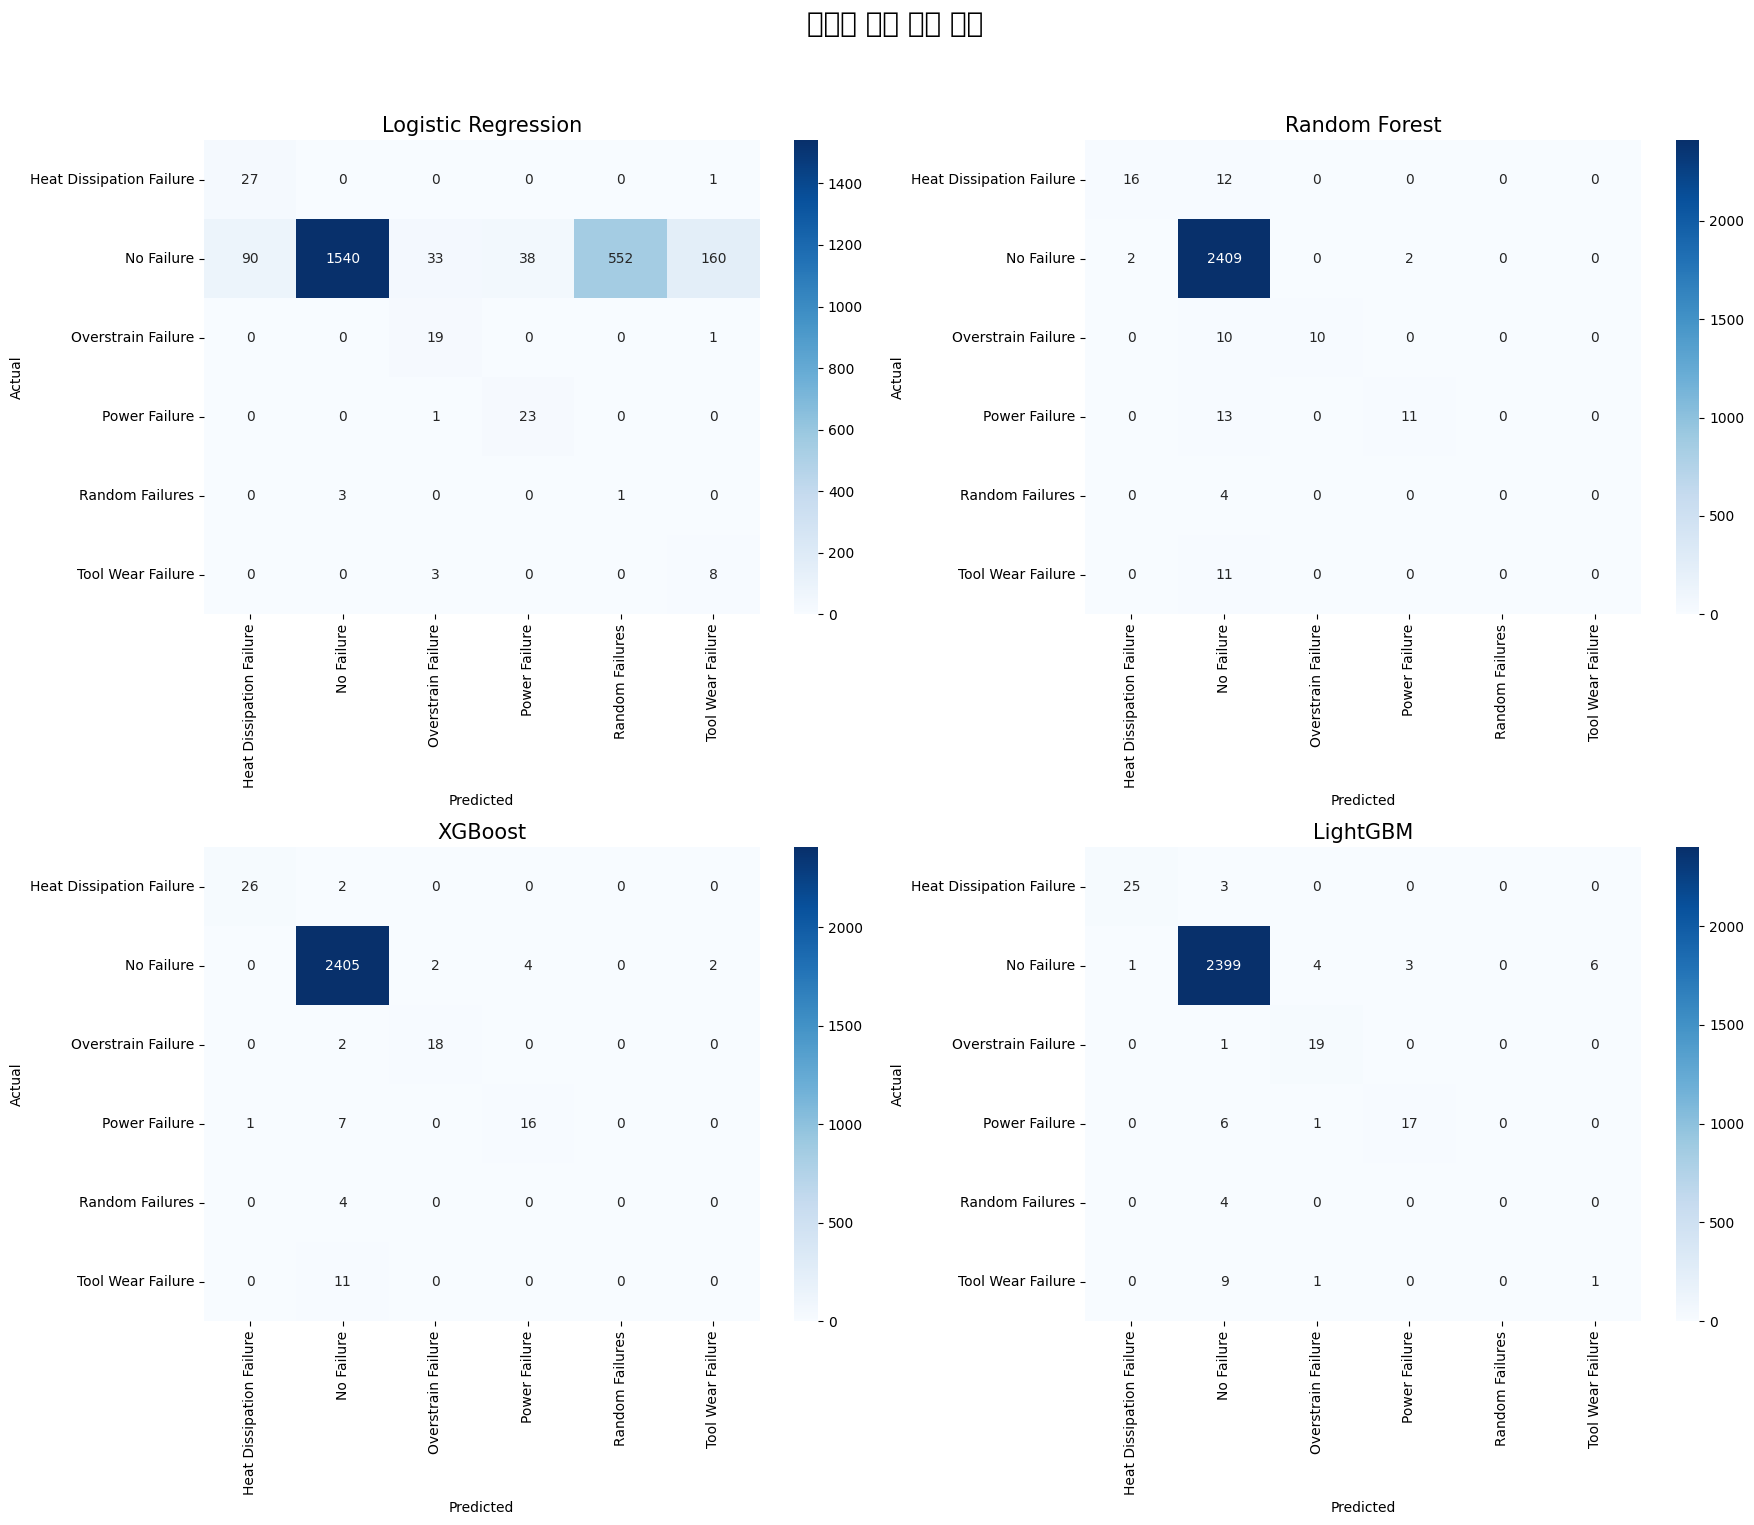

In [30]:
# --- 5.3 모델별 혼동 행렬 시각화 ---
fig, axes = plt.subplots(2, 2, figsize=(18, 16))
fig.suptitle('모델별 혼동 행렬 비교', fontsize=20)
axes = axes.flatten()

for i, (name, pred) in enumerate(predictions.items()):
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                xticklabels=le.classes_, yticklabels=le.classes_)
    axes[i].set_title(name, fontsize=15)
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

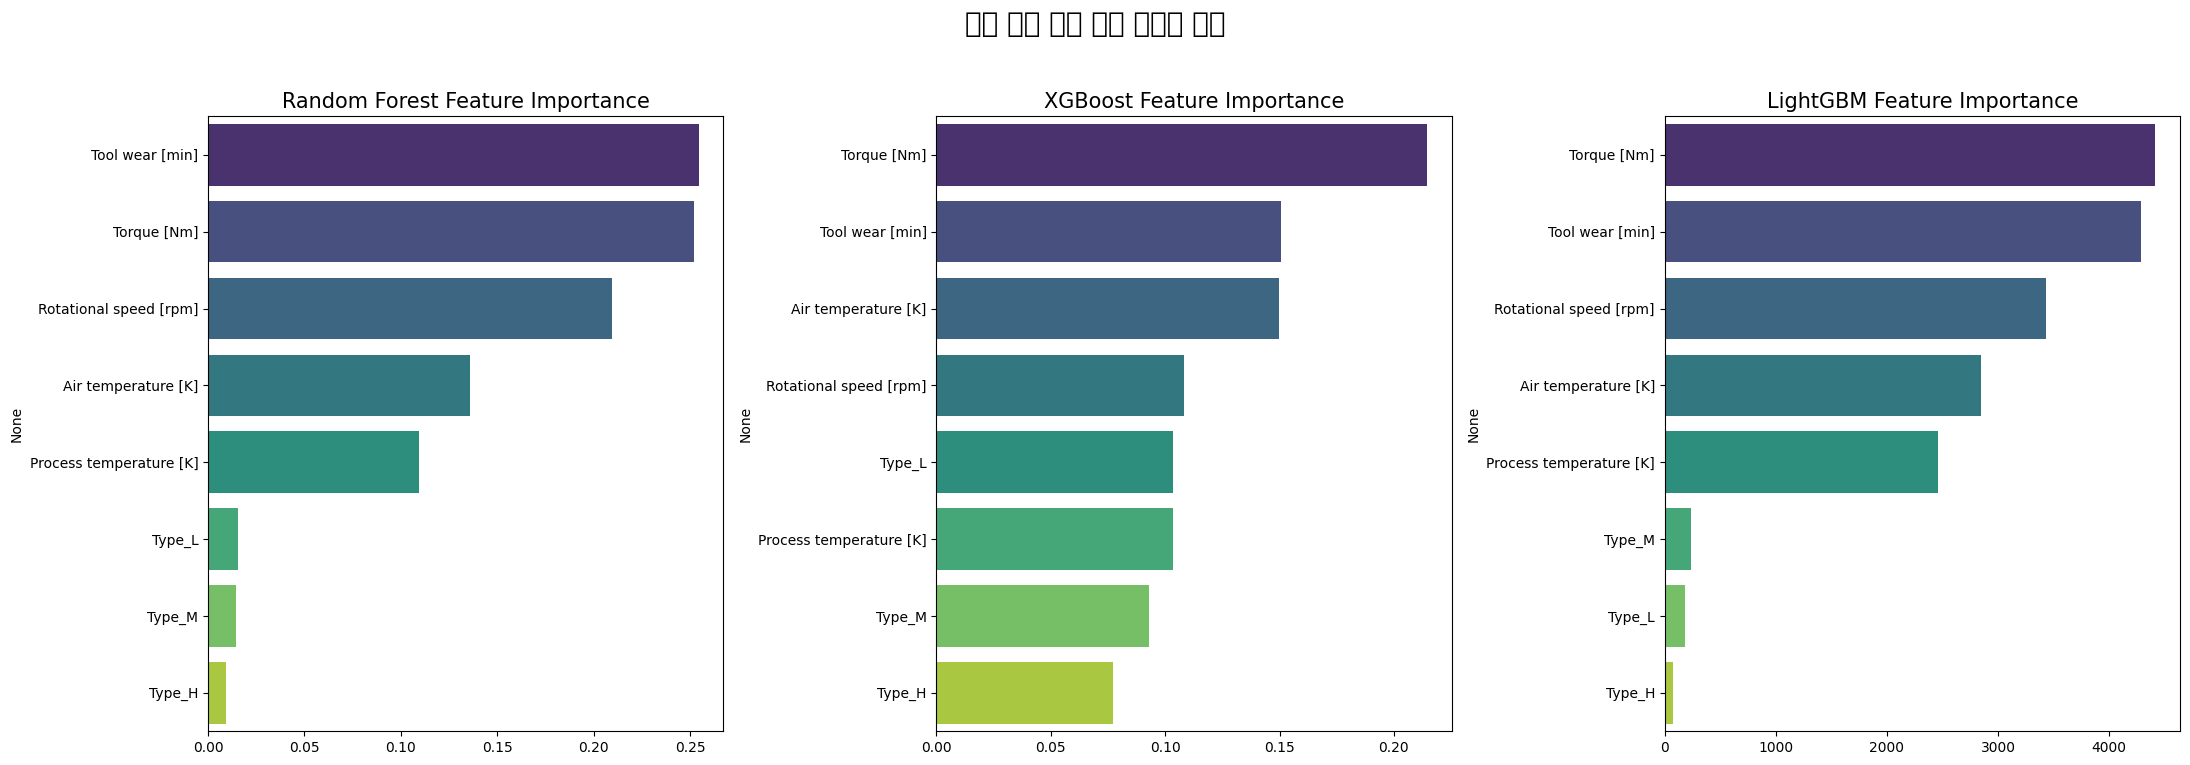

In [31]:
# --- 5.4 트리 기반 모델 피처 중요도 비교 ---
fig, axes = plt.subplots(1, 3, figsize=(22, 8))
fig.suptitle('트리 기반 모델 피처 중요도 비교', fontsize=20)

# 원본 컬럼명 복원
cat_cols = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = numeric_features + list(cat_cols)

tree_models = {'Random Forest': models['Random Forest'], 'XGBoost': models['XGBoost'], 'LightGBM': models['LightGBM']}
for i, (name, model) in enumerate(tree_models.items()):
    importances = pd.Series(model.feature_importances_, index=all_feature_names)
    top10 = importances.nlargest(10)
    sns.barplot(x=top10.values, y=top10.index, ax=axes[i], palette='viridis')
    axes[i].set_title(f'{name} Feature Importance', fontsize=15)
    axes[i].tick_params(axis='x', labelsize=10)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()